In [149]:
import quantstats as qs
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.colors import LinearSegmentedColormap
from quantstats.stats import *
from quantstats._plotting.wrappers import distribution
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import df2img
from datetime import date
from datetime import datetime

# my imports
import sys
sys.path.insert(1, '../scripts')
import utils as utl
import html_evaluation_portfolio as hep
import volatility_estimator as ve
import mean_rev_utl as mru

## Importing and processing data

In [193]:
#parameters
short = 20
long = 120

#inverse volatility parameters
window = 30 #days
estimator = 'stdv' #'eq_weight' #'satchell'
weighting = 'inverse_vol' #'vol' 

USequity_list = ['SPY', 'DIA', 'QQQ', 'MDY', 'IJR', 'IWC', 'VUG',
                'VGT', 'ITOT', 'XLV', 'VNQ', 'IWD', 'XLE', 'XLF', 'SCHB'] #[] #['SPY', 'DIA', 'QQQ', 'MDY', 'IWC', 'IJR'] #['MDY', 'QQQ']  'IJR'  # 
GLOBequity_list = ['ACWI', 'ADRE', 'SPDW', 'VEA', 'IEFA', 'DGT', 'IOO',
                  'DIM', 'EFV', 'VWO', 'FM', 'SPEU', 'ASEA', 'SCZ', 'GWX'] #['ACWI', 'SPDW', 'VEA', 'IEFA', 'ADRE']#['IEFA', 'VEA', 'ADRE'] #['ACWI', 'SPDW', 'VEA', 'IEFA'] # 'ADRE'  #
bond_list = ['TLT', 'BND', 'TIP', 'PHB', 'BWX', 'VCSH', 'GBF', 
            'BSV', 'PLW', 'IGIB', 'IGSB', 'WIP', 'PWZ', 'CWB', 'SPTI'] #['TLT', 'BND', 'TIP', 'PHB', 'VCSH', 'BWX'] #['TLT', 'PHB', 'VCSH'] #['TLT', 'BND', 'TIP', 'PHB', 'VCSH'] # 'BWX'  #
commodities_list = ['DBB', 'GLD', 'SLV', 'PPLT', 'DBA', 'DBO', 'UNG', 
                    'CORN', 'SOYB', 'DBE', 'USO', 'UGA', 'GRU', 'GSG', 'FUE'] #['GLD', 'DBA', 'DBO', 'UNG', 'CORN', 'SLV', 'DBB', 'PPLT', 'SOYB']#['SLV', 'DBB', 'DBO', 'GLD'] #['DBB', 'GLD', 'DBA', 'DBO', 'UNG', 'CORN'] # 'SLV', 'PPLT', 'SOYB'  #
currencies = ['UUP', 'CYB', 'FXB', 'FXE', 'FXY', 'FXA', 'ULE', 'FXC',
               'FXF', 'DVB', 'UND', 'CEW', 'USDU', 'EUO', 'YCL'] #['UUP', 'CYB', 'FXB', 'FXE', 'FXY'] #['CYB']  # # 

list_securities = USequity_list + GLOBequity_list + bond_list + commodities_list + currencies
debug_xl = False

start_date = '2006-01-03'
end_date = "2020-11-26"

In [194]:
US_equity = pd.read_csv('../data/key_market_USequties.csv', index_col = 0, header = [0,1])
global_equity = pd.read_csv('../data/key_market_GLOBequties.csv', index_col = 0, header = [0,1])
bonds = pd.read_csv('../data/key_market_bonds.csv', index_col = 0, header = [0,1])
currencies = pd.read_csv('../data/key_market_currencies.csv', index_col = 0, header = [0,1])
commodities = pd.read_csv('../data/key_market_commodities.csv', index_col = 0, header = [0,1])
df_tot = pd.concat([US_equity, global_equity, bonds, currencies, commodities], axis = 1)
df_close = df_tot.iloc[:, df_tot.columns.get_level_values(1)=='Close']
df_close.columns = df_close.columns.droplevel(1)
data = df_close[start_date:end_date]
data = data[list_securities] 

In [152]:
#df_close = df_tot.iloc[:, df_tot.columns.get_level_values(1)=='Close']
#df_close.columns = df_close.columns.droplevel(1)
#
#df_volume = df_tot.iloc[:, df_tot.columns.get_level_values(1)=='Volume']
#df_volume.columns = df_volume.columns.droplevel(1)
#
#df_close.to_csv('../data/close_price_75_ETFs.csv')
#df_volume.to_csv('../data/volume_75_ETFs.csv')

In [195]:
#compute unique names
title = ''
unique_name = 'MATS+' + weighting + estimator
for i in list_securities:
        unique_name += '_' + i
        title += i + ' '
title += 'short '+ str(short) + ' long '+ str(long) + 'estimator: ' + estimator 
unique_name = unique_name + '_short_' + str(short) + '_long_'+ str(long)
title = 'All ETFs report'
unique_name = 'all_75_etfs_stdv_inv_vol_weight'

### Mean average strategy

In [196]:
def create_mean_rev_signal(data, long_wind, short_wind):
    '''
    input 
    data: pandas dataframe with prices of securities (name of the column security)
    long_wind: the long window you want for the mean reverse strategy
    short_wind: the short windw you want for the mean reverse strategy
    
    output:
    final_df: pandas df filled with 1 or -1 accordingly to the mean reverse strategy
    df_rolling_mean: df with the means over the different windows for debugging
    '''
    final_df = pd.DataFrame()
    df_rolling_mean = pd.DataFrame()
    for sec in data.columns:
        sec_df = pd.DataFrame(columns = [sec])
        long_wind_df = data[sec].rolling(long_wind).mean() #creating the long window df
        df_rolling_mean[sec + '_long'] = long_wind_df #for debugging
        short_wind_df = data[sec].rolling(short_wind).mean() #creating the short window df
        df_rolling_mean[sec + '_short'] = short_wind_df #for debugging
        sec_df[sec] = (short_wind_df - long_wind_df) #subtracting the long and the short
        sec_df[sec] = sec_df[sec].apply(lambda x: 1 if x>0 else -1) #subsitute positive value with 1 and negative with a -1
        final_df[sec] = sec_df[sec]
    return final_df, df_rolling_mean

def filter_dataframe_holc(df_tot, list_securities):
    df_output = pd.DataFrame()
    for security in list_securities:
        df_output[security + '_open'] = df_tot[security]['Open']
        df_output[security + '_high'] = df_tot[security]['High']
        df_output[security + '_low'] = df_tot[security]['Low']
        df_output[security + '_close'] = df_tot[security]['Close']
        #df_output.dropna(inplace = True)
    return df_output

from math import isnan

def number_nan(row):
    count = 0
    for i in range(len(row)):
        if isnan(row[i]):
            count += 1
    return len(row)-count

In [197]:
#main

signal_df = mru.create_mean_rev_signal(data, long, short)[0]
#new_index = signal_df.index.strftime('%Y-%m-%d')
#signal_df.set_index(new_index, inplace = True)

df_rolling_mean = mru.create_mean_rev_signal(data, long, short)[1]
data_r = data.div(data.shift(1))-1 #returns of securities

C:\Users\zazzo\OneDrive\Desktop\betagen\signal_strategy\notebooks\../scripts\mean_rev_utl.py:19: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\zazzo\OneDrive\Desktop\betagen\signal_strategy\notebooks\../scripts\mean_rev_utl.py:21: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\zazzo\OneDrive\Desktop\betagen\signal_strategy\notebooks\../scripts\mean_rev_utl.py:19: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

C:\Users\zazzo\OneDrive\Desktop\betagen\signal_strategy\notebooks\../scripts\mean_rev_utl.py:19: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\zazzo\OneDrive\Desktop\betagen\signal_strategy\notebooks\../scripts\mean_rev_utl.py:21: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\zazzo\OneDrive\Desktop\betagen\signal_strategy\notebooks\../scripts\mean_rev_utl.py:19: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

C:\Users\zazzo\OneDrive\Desktop\betagen\signal_strategy\notebooks\../scripts\mean_rev_utl.py:21: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



### Inverse probability weighting

In [198]:
# startegy: creating different df_weighted and signal_df accordingly with the parameters (estimtor, weghting) choosen.

if estimator == 'eq_weight':
    signal_df_eq_weight = signal_df.copy()
    signal_df_eq_weight['n_sec_active'] = signal_df_eq_weight.apply(number_nan, axis = 1)
    signal_df_eq_weight = signal_df_eq_weight.apply(lambda row: row/row['n_sec_active'], axis = 1)
    signal_df_eq_weight.drop(columns =['n_sec_active'], inplace = True)
    signal_df = signal_df_eq_weight
    df_weighted = pd.DataFrame(1, index=signal_df_eq_weight.index, columns=signal_df_eq_weight.columns)

if estimator == 'satchell':
    data_ohlc = filter_dataframe_holc(df_tot, list_securities)
    data_ohlc = data_ohlc[start_date: end_date]
    df_satchell_volat = ve.compute_satchell_volatility(data_ohlc, list_securities, window)
    try:
        df_satchell_volat = ve.index_df(df_satchell_volat, data, window)
    except ValueError:
        df_satchell_volat = ve.index_df(df_satchell_volat, data, window+1)
    if weighting == 'inverse_vol':
        df_satchell_inv_volat = df_satchell_volat.applymap(lambda x: 1/x)
        df_weighted = hep.df_wheighted(df_satchell_inv_volat.fillna(0))
    if weighting == 'vol':
        df_weighted = hep.df_wheighted(df_satchell_volat.fillna(0))
   
if estimator == 'stdv':    
    df_strd_dev = ve.dataframe_strd_dev(data, window) #create standard dev dataframe
    df_strd_dev = ve.index_df(df_strd_dev, data, window) #reindex accordingly to data
    data_perc = hep.return_df(data) #compute the returns
    if weighting == 'inverse_vol':
        inv_volat_data = hep.df_inverse_volatility(data_perc, window) #compute the inverse volatility dataframe
        df_weighted = hep.df_wheighted(inv_volat_data.fillna(0)) #normalize the rows for the weights
    if weighting == 'vol':
        df_weighted = hep.df_wheighted(df_strd_dev.fillna(0)) #normalize the rows for the weights

In [199]:
# compute data earnings
data_earnings = hep.df_earnings((signal_df * df_weighted), data_r.fillna(0))
#data_earnings.dropna(inplace = True)
data_earnings.index = pd.to_datetime(data_earnings.index)

ciao
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello


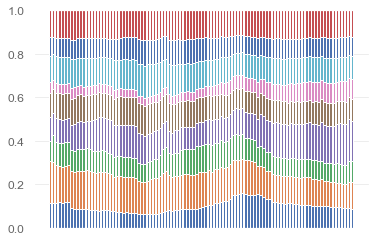

In [158]:
fig, ax = plt.subplots()
#tic = datetime.now()

for i,sec in enumerate(df_weighted.columns):
    if i == 0: 
        ax.bar(df_weighted.index[400:500], df_weighted[sec][400:500], label = sec)
        print('ciao')
    else:   
        bottom = df_weighted[list(df_weighted.columns)[:i]][400:500] 
        ax.bar(df_weighted.index[400:500], df_weighted[sec][400:500], label = sec, bottom = bottom.sum(axis = 1)) 
        print('hello')
#plt.legend(loc = 'best')
ax.axes.get_xaxis().set_ticks([])
plt.show()

ciao
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello


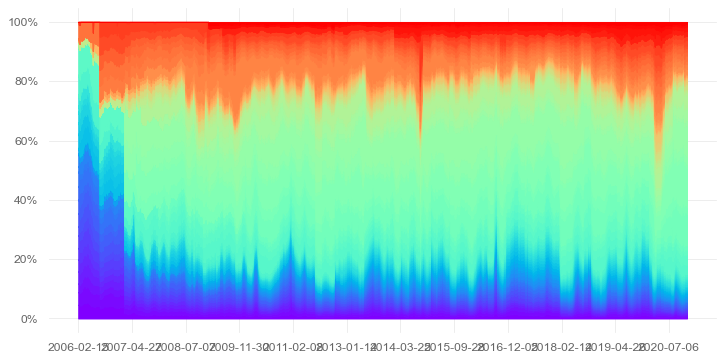

In [213]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
from quantstats._plotting.core import format_pct_axis
from matplotlib.ticker import (
    FormatStrFormatter as _FormatStrFormatter,
    FuncFormatter as _FuncFormatter)



colors = plt.cm.rainbow(np.linspace(0, 1, len(df_weighted.columns)))

fig, ax = plt.subplots(figsize=(12,6))
#tic = datetime.now()

#df_weighted.dropna(inplace = True)

for i,sec in enumerate(df_weighted.columns):
    if i == 0: 
        #ax.plot(df_weighted.index, df_weighted[sec], label = sec, color = colors[i]) 
        ax.fill_between(df_weighted.index, df_weighted[sec], 0, color = colors[i], label = sec)
        print('ciao')
    else:   
        bottom = df_weighted[list(df_weighted.columns)[:i]]
        #ax.plot(df_weighted.index, df_weighted[sec] + bottom.sum(axis = 1), label = sec, color = colors[i]) 
        ax.fill_between(df_weighted.index, df_weighted[sec] + bottom.sum(axis = 1), bottom.sum(axis = 1), color = colors[i], label = sec)
        print('hello')
#plt.legend( loc = 'best')

ax.axes.get_xaxis().set_ticks(df_weighted.index[::300])
ax.yaxis.set_major_formatter(_FuncFormatter(format_pct_axis))
plt.show()

In [160]:
data

,DBB,GLD,SLV,PPLT,DBA,DBO,UNG,CORN,SOYB,DBE,USO,UGA,GRU,GSG,FUE
Date,,,,,,,,,,,,,,,
2006-01-03,NaN,53.119999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04,NaN,53.299999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-05,NaN,52.340000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-06,NaN,53.720001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-09,NaN,54.599998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-19,16.770000,175.160004,22.420000,89.220001,15.40,7.39,9.90,14.14,17.850000,9.70,29.090000,19.980000,3.26,11.20,6.42
2020-11-20,16.959999,175.690002,22.490000,89.110001,15.39,7.45,10.05,14.16,17.879999,9.79,29.270000,20.150000,3.26,11.29,6.42
2020-11-23,16.700001,172.229996,21.930000,87.120003,15.51,7.53,10.21,14.31,18.059999,9.86,29.520000,20.480000,3.34,11.37,6.85


In [161]:
# excel debug

if debug_xl == True:
        with pd.ExcelWriter('AW_dbg.xlsx') as writer:
            new_index = data.index.tz_convert(None)
            data.set_index(new_index).to_excel(writer, sheet_name='prices')
            new_index = data_r.index.tz_convert(None)
            data_r.set_index(new_index).to_excel(writer, sheet_name='returns')
            new_index = signal_df.index.tz_convert(None)
            signal_df.set_index(new_index).to_excel(writer, sheet_name='signals')
            new_index = df_rolling_mean.index.tz_convert(None)
            df_rolling_mean.set_index(new_index).to_excel(writer, sheet_name='rolling mean')
            new_index = data_earnings.index.tz_convert(None)
            data_earnings.set_index(new_index).to_excel(writer, sheet_name='AW_port_rets')

In [162]:
data_earnings[120:]

,DBB,GLD,SLV,PPLT,DBA,DBO,UNG,CORN,SOYB,DBE,USO,UGA,GRU,GSG,FUE,Tot
Date,,,,,,,,,,,,,,,,
2006-06-26,NaN,0.001743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001743
2006-06-27,NaN,-0.003572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003572
2006-06-28,NaN,-0.000844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000844
2006-06-29,NaN,0.012134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012134
2006-06-30,NaN,-0.009757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-19,0.000832,-0.000158,-0.000245,-0.000499,-0.000627,-0.000053,0.001130,-0.000504,0.000267,-0.000051,-0.000122,-0.000274,-0.000466,-0.000069,0.000000,-0.000840
2020-11-20,0.001564,0.000254,0.000132,-0.000065,-0.000104,-0.000325,-0.000457,0.000126,0.000161,-0.000466,-0.000248,-0.000335,0.000000,0.000630,0.000000,0.000866
2020-11-23,-0.002220,-0.001678,-0.001149,-0.001193,0.001208,-0.000419,-0.000482,0.000938,0.000975,-0.000349,-0.000334,-0.000636,0.000735,0.000535,0.001911,-0.002154


#### Sharpe ratio table

C:\Users\zazzo\.virtualenvs\betagen-ySXfpur7\lib\site-packages\quantstats\stats.py:293: RuntimeWarning:

invalid value encountered in double_scalars



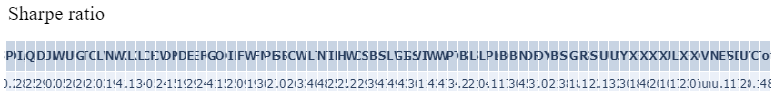

In [201]:
from quantstats.stats import sharpe
      

sharpe_r_df = pd.DataFrame(columns = data_earnings.columns, index = ['Sharpe ratio'])
for sec in data_earnings.columns:
    sharpe_r_df[sec] = sharpe(data_earnings[sec])

sharpe_r_df  

fig = df2img.plot_dataframe(
    sharpe_r_df.round(3),
    print_index=False,
    title=dict(
        font_color="black",
        font_family="Times New Roman",
        font_size=20,
        text="Sharpe ratio"),
    fig_size=(775, 100),

   )

df2img.save_dataframe(fig=fig, filename='../img/sharpe_ratio' + unique_name + '.png')
#fig_stats = fig

## Create and export plot for the report

#### Table of returns:

In [202]:
#param
figsize=(10, 5.5)
fontname = 'Arial'
annot_size=10
square = False
cbar = False
cmap = LinearSegmentedColormap.from_list('RedGreen', ['crimson', 'gold', 'lime'])
eoy = False
compounded = True

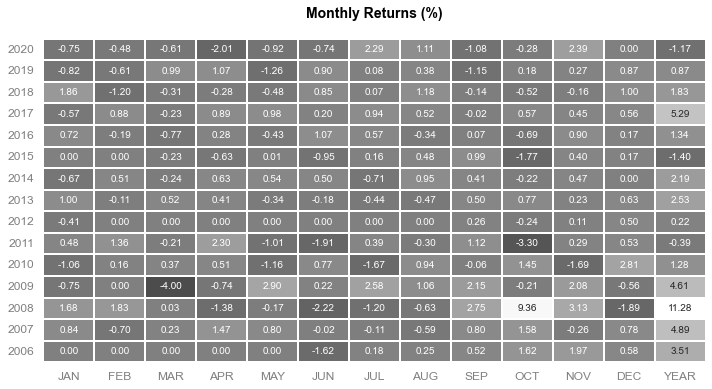

In [203]:
#crate the returns table plus the return over the year

fig, ax = plt.subplots(figsize=figsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.set_facecolor('white')
ax.set_facecolor('white')

ax.set_title('Monthly Returns (%)\n', fontsize=14, y=.995,
             fontname=fontname, fontweight='bold', color='black')

returns = monthly_returns(data_earnings['Tot'], eoy=eoy,compounded=compounded) * 100

#print(returns.div(100).add(1).cumprod(axis = 1)) #replace(0,1).cumprod(axis=1)['DEC']
returns['YEAR'] = returns.div(100).add(1).cumprod(axis = 1)['DEC']
returns['YEAR'] = returns['YEAR'].sub(1).mul(100)
#yearly_returns = returns.div(100).add(1).cumprod(axis=1)['DEC'] - 1
#returns['YEAR'] = yearly_returns *100
#returns

reversed_df = returns.iloc[::-1]

#display(returns)

ax = sns.heatmap(reversed_df, ax=ax, annot=True, center=0,
                annot_kws={"size": annot_size}, vmax = 10,
                fmt="0.2f", linewidths=2,
                square=square, cbar=cbar, cmap = 'gray',
                cbar_kws={'format': '%.0f%%'})

ax.tick_params(colors="#808080")
plt.xticks(rotation=0, fontsize=annot_size*1.2)
plt.yticks(rotation=0, fontsize=annot_size*1.2)
plt.subplots_adjust(hspace=0, bottom=0, top=1)
fig.tight_layout(w_pad=0, h_pad=0)
fig_table = fig 
plt.savefig('../img/temp/table_montly_returns'+ unique_name + '.png')

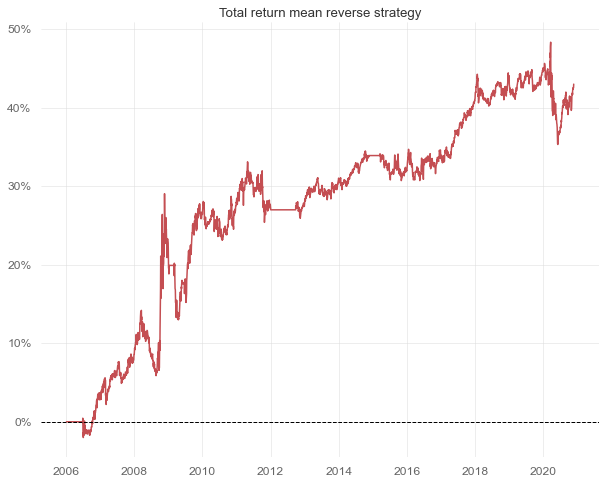

In [204]:
from quantstats.stats import compsum
from quantstats._plotting.core import format_pct_axis
from matplotlib.ticker import (
    FormatStrFormatter as _FormatStrFormatter,
    FuncFormatter as _FuncFormatter
)

#bench_return_try = bench_return[700:800]
#returns = dict_df['x1 leverage']['Tot']
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Total return mean reverse strategy')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(compsum(data_earnings['Tot']), lw=1.5, color='r', alpha=1)
ax.axhline(0, ls="--", lw=1, color="#000000", zorder=2)
ax.yaxis.set_major_formatter(_FuncFormatter(format_pct_axis))
#ax.legend()
fig = ax.get_figure()
fig.set_size_inches(10,8)
fig.savefig('../img/returns_'+ unique_name + '.png')

In [167]:
#fig, ax = plt.subplots(figsize=(10,8))
#ax.set_title('SPY mean reverse strategy returns')
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)
#fig.set_facecolor('white')
#ax.set_facecolor('white')
#ax.plot(compsum(data_earnings['SPY']), lw=1.5, color='r', alpha=1)
#ax.axhline(0, ls="--", lw=1, color="#000000", zorder=2)
#ax.yaxis.set_major_formatter(_FuncFormatter(format_pct_axis))
##ax.legend()
#fig = ax.get_figure()
#fig.set_size_inches(10,8)
#fig.savefig('../img/SPY_ret_MATS_long_80_short_20.png')

#### Distribution plot:

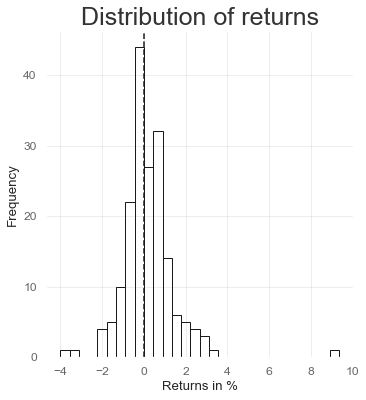

In [205]:
returns = monthly_returns(data_earnings['Tot'], eoy=eoy,compounded=compounded) * 100

series = pd.Series(dtype = 'float64')
for column in returns.columns:
    series = pd.concat([series,returns[column]])
#distribution(returns)
ax = series.plot.hist(bins = 30, edgecolor='k',fill=False)
ax.set_title('Distribution of returns', size = 25)
ax.axvline(0, color='k', linestyle='--')
ax.set_xlabel("Returns in %")
ax.set_ylabel("Frequency")
fig = ax.get_figure()
fig.set_size_inches(5.5,6)
fig.savefig('../img/temp/distribution_returns' + unique_name + '.png')
fig_distribution = fig

#### Table of statistics:

In [206]:
# create table of stats

statistics = pd.DataFrame(columns = ['index', 'value'])

statistics.loc[0] = ['Annualised return', utl.annualized_return(data_earnings['Tot'])]
statistics.loc[1] = ['Annualised volatility', utl.annualised_volatility(data_earnings['Tot'])]
statistics.loc[2] = ['Sharpe ratio', sharpe(data_earnings['Tot'])]
statistics.loc[3] = ['Sortino ratio', sortino(data_earnings['Tot'])]
statistics.loc[4] = ['Adjusted sortino', adjusted_sortino(data_earnings['Tot'])] 
statistics.loc[5] = ['Skew', skew(data_earnings['Tot'])] 
statistics.loc[6] = ['Kurtosis', data_earnings['Tot'].kurt()] 
statistics.loc[7] = ['Max drawdown', max_drawdown(data_earnings['Tot'])] 
statistics.loc[8] = ['GPR', gain_to_pain_ratio(data_earnings['Tot'])] 
statistics.loc[9] = ['Calmar ratio', calmar(data_earnings['Tot'])] 
statistics.loc[10] = ['Pay-off ratio', payoff_ratio(data_earnings['Tot'])] 

# Annualised return (At top)
# Annualizwed volatility (At top)

#export as .csv
statistics.to_csv('../data/temp/statistics_all_weather' + unique_name + '.csv')

statistics


,index,value
0,Annualised return,0.025383
1,Annualised volatility,0.052468
2,Sharpe ratio,0.483920
3,Sortino ratio,0.685430
4,Adjusted sortino,0.484672
5,Skew,-0.313167
6,Kurtosis,24.867870
7,Max drawdown,-0.124455
8,GPR,0.114383
9,Calmar ratio,0.195129


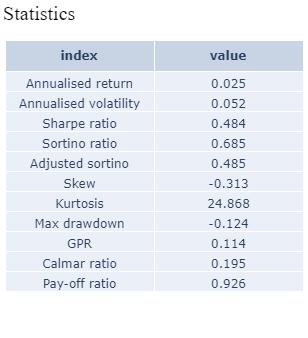

In [207]:
#transform pd. dataframe to image

fig = df2img.plot_dataframe(
    statistics.round(3),
    print_index=False,
    title=dict(
        font_color="black",
        font_family="Times New Roman",
        font_size=20,
        text="Statistics"),
    fig_size=(308, 338),

   )

df2img.save_dataframe(fig=fig, filename='../img/temp/statistics_all_weather' + unique_name + '.png')

fig_stats = fig
#statistics.to_csv('./img/temp/statistics_all_weather' + unique_name + '.csv')

In [208]:
# Param
grayscale=True 
figsize= (10, 5.5)
fontname='Arial' 
lw=1
log_scale=False
match_volatility=False
compound=False
ylabel="Drawdown"
resample=None 
subtitle=True 
savefig =  '../img/temp/under_water_plot' + unique_name + '.png'
show=True

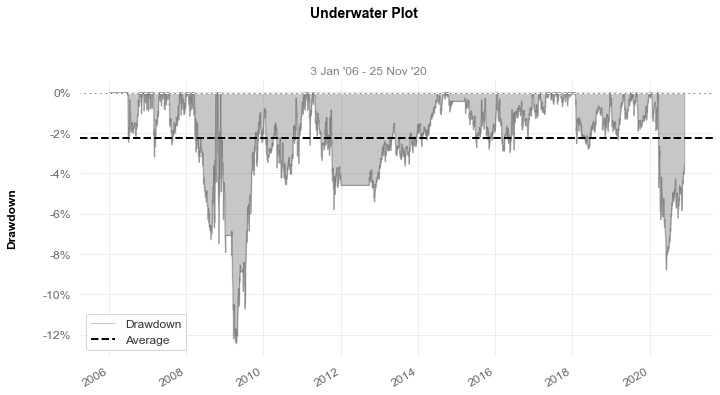

In [209]:
from quantstats._plotting.core import plot_timeseries

dd = to_drawdown_series(data_earnings['Tot'])
#bench_dd = to_drawdown_series(benchmark_portf_perc['TOT'])

fig = plot_timeseries(dd, title='Underwater Plot',
                            hline=dd.mean(), hlw=2, hllabel="Average",
                            returns_label="Drawdown",
                            compound=compound, match_volatility=match_volatility,
                            log_scale=log_scale, resample=resample,
                            fill=True, lw=lw, figsize=figsize,
                            ylabel=ylabel,
                            fontname=fontname, grayscale=grayscale,
                            subtitle=subtitle,
                            savefig=savefig, show=show)
fig

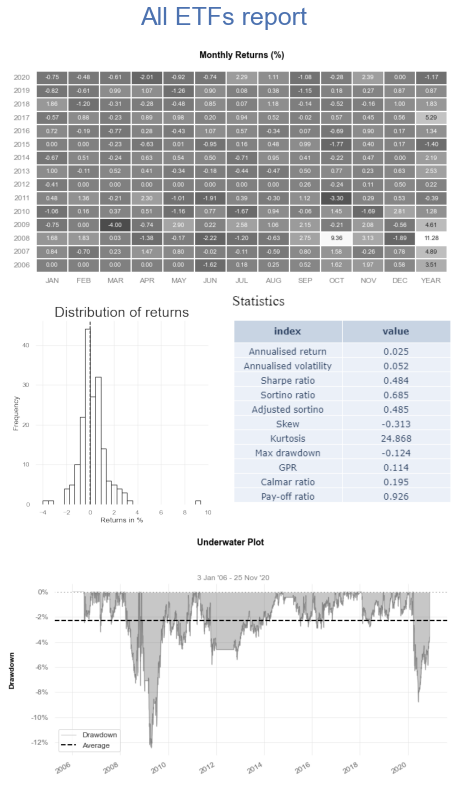

In [210]:
fig = plt.figure(figsize=(8, 13.55))
gs = gridspec.GridSpec(3, 2, wspace=0.0, hspace=0.0)
ax1 = plt.subplot(gs[0, :])
fig_table = plt.imread('../img/temp/table_montly_returns' + unique_name + '.png')
ax1.imshow(fig_table)
ax1.set_aspect('equal')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.grid(False)

ax2 = plt.subplot(gs[1,:1])
fig_distribiution = plt.imread('../img/temp/distribution_returns' + unique_name + '.png')
ax2.imshow(fig_distribiution)
ax2.set_aspect('equal')
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.grid(False)

ax3 = plt.subplot(gs[1, 1:])
fig_stats = plt.imread('../img/temp/statistics_all_weather' + unique_name + '.png')
ax3.imshow(fig_stats)
ax3.set_aspect('equal')
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.grid(False)
    
ax4 = plt.subplot(gs[-1,:])
fig_underwater = plt.imread('../img/temp/under_water_plot' + unique_name + '.png')
ax4.imshow(fig_underwater)
ax4.set_aspect('equal')
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.grid(False)

fig.suptitle(title, fontsize=25, y = 0.92, color = 'b') #add the correct leverage

plt.savefig('../reports/report_' + unique_name + '.png', dpi = 1200)

In [174]:
unique_name

'MATS+inverse_volstdv_DBB_GLD_SLV_PPLT_DBA_DBO_UNG_CORN_SOYB_DBE_USO_UGA_GRU_GSG_FUE_short_20_long_120'

## Buy and hold strategy -- Baseline

In [211]:
data_r = data.div(data.shift(1))-1 #returns of securities
buy_and_hold_returns = data_r.copy()
buy_and_hold_returns['Tot'] = buy_and_hold_returns.sum(axis= 1)
buy_and_hold_returns.index = pd.to_datetime(buy_and_hold_returns.index)
buy_and_hold_returns['n_sec_active'] = buy_and_hold_returns.drop(columns = ['Tot']).apply(number_nan, axis = 1)
buy_and_hold_returns['Tot'] = buy_and_hold_returns['Tot']/buy_and_hold_returns['n_sec_active']
buy_and_hold_returns.drop(columns = ['n_sec_active'], inplace = True)
buy_and_hold_returns

,SPY,DIA,QQQ,MDY,IJR,IWC,VUG,VGT,ITOT,XLV,...,ULE,FXC,FXF,DVB,UND,CEW,USDU,EUO,YCL,Tot
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04,0.004736,0.003785,0.010409,0.007095,0.005611,0.007892,0.007738,0.013190,0.005767,0.009966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006731
2006-01-05,0.000628,0.001288,0.004312,0.001453,0.003043,0.006494,0.000182,0.009213,-0.000353,-0.002467,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000752
2006-01-06,0.008322,0.005878,0.018130,0.011387,0.008764,0.010057,0.010053,0.015876,0.009267,0.006492,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011421
2006-01-09,0.002569,0.004200,0.003983,0.004518,0.009858,0.008078,0.004886,0.004298,0.005246,0.004607,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-19,0.004210,0.001934,0.007825,0.008929,0.005869,0.004259,0.007839,0.010953,0.005540,-0.000733,...,0.003351,0.001063,0.001399,NaN,NaN,0.005531,-0.000386,-0.004595,0.001686,0.002198
2020-11-20,-0.006848,-0.007289,-0.006841,-0.000689,-0.001072,0.005842,-0.007402,-0.008027,-0.005265,-0.002293,...,-0.004008,-0.001991,-0.000798,NaN,NaN,-0.004951,-0.003088,0.003777,-0.001010,0.001044
2020-11-23,0.005994,0.011486,0.000035,0.015542,0.023248,0.021641,0.001432,0.000646,0.008124,-0.002574,...,-0.000671,0.000133,-0.001598,NaN,NaN,-0.003317,0.004259,0.001672,-0.013985,0.004514


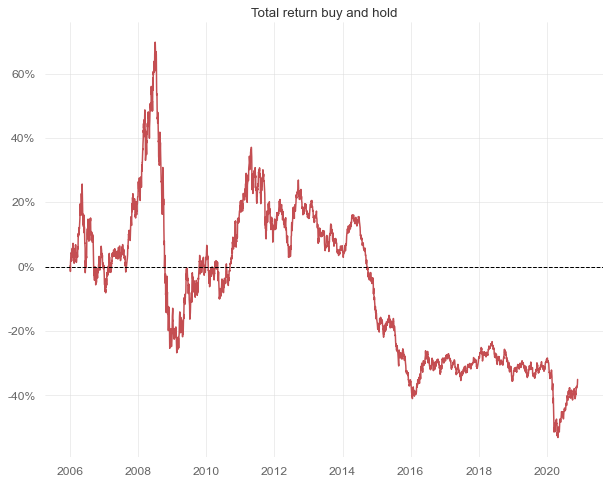

In [176]:
from quantstats.stats import compsum
from quantstats._plotting.core import format_pct_axis
from matplotlib.ticker import (
    FormatStrFormatter as _FormatStrFormatter,
    FuncFormatter as _FuncFormatter
)

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Total return buy and hold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(compsum(buy_and_hold_returns['Tot']), lw=1.5, color='r', alpha=1)
ax.axhline(0, ls="--", lw=1, color="#000000", zorder=2)
ax.yaxis.set_major_formatter(_FuncFormatter(format_pct_axis))
#ax.legend()
fig = ax.get_figure()
fig.set_size_inches(10,8)
fig.savefig('../img/returns_base_line.png')

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2006-01-03  2006-01-03
End Period                 2020-11-25  2020-11-25
Risk-Free Rate             0.0%        0.0%
Time in Market             89.0%       100.0%

Cumulative Return          42.99%      82.11%
CAGR﹪                     2.43%       4.1%

Sharpe                     0.48        0.4
Prob. Sharpe Ratio         96.81%      93.79%
Smart Sharpe               0.48        0.4
Sortino                    0.69        0.55
Smart Sortino              0.68        0.55
Sortino/√2                 0.48        0.39
Smart Sortino/√2           0.48        0.39
Omega                      1.11        1.11

Max Drawdown               -12.45%     -38.07%
Longest DD Days            1219        1191
Volatility (ann.)          5.25%       11.74%
R^2                        0.09        0.09
Information Ratio          -0.01       -0.01
Calmar                     0.2         0

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-11-21,2009-04-17,2011-01-18,788,-12.445461,-12.194976
2,2020-03-24,2020-06-08,2020-11-25,246,-8.781337,-8.578873
3,2008-10-28,2008-11-04,2008-11-20,23,-7.476058,-5.954067
4,2008-03-18,2008-08-21,2008-10-06,202,-7.279952,-6.988927
5,2011-05-02,2011-10-27,2014-09-02,1219,-5.790863,-5.047008


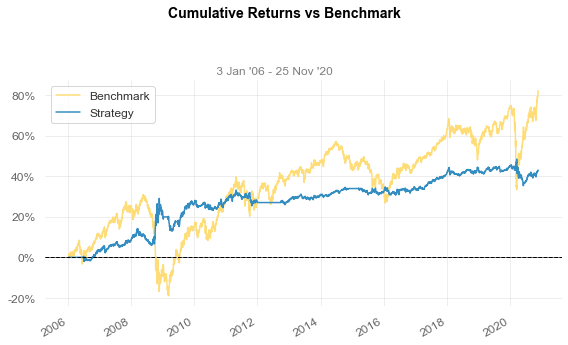

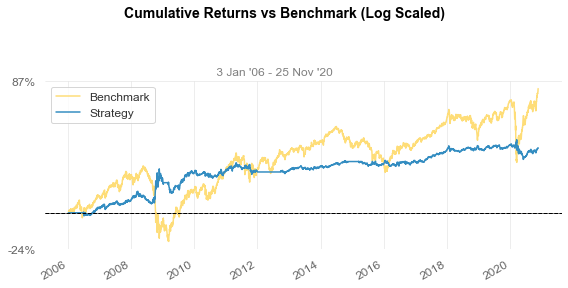

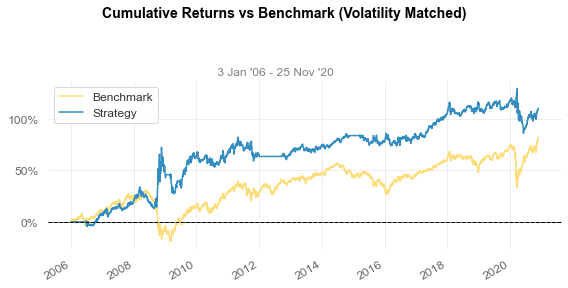

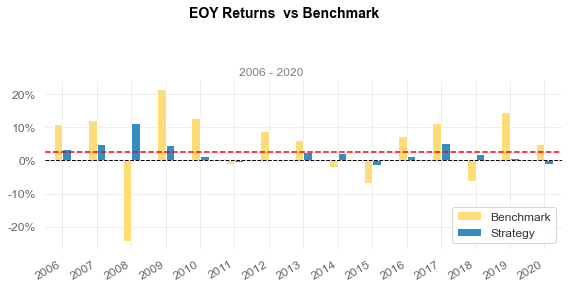

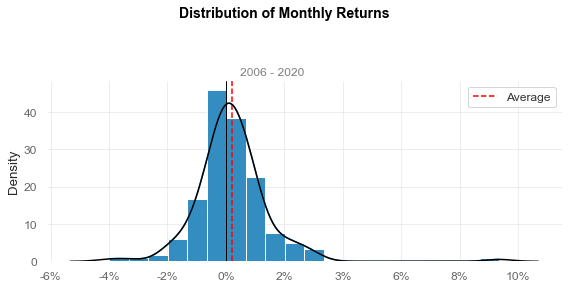

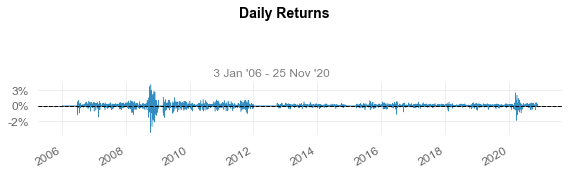

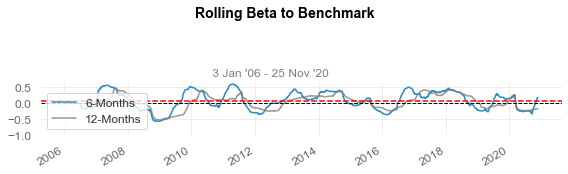

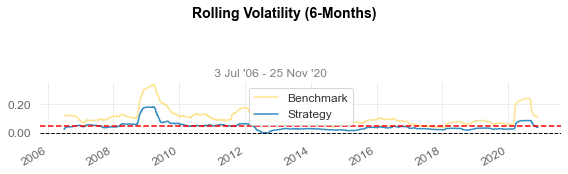

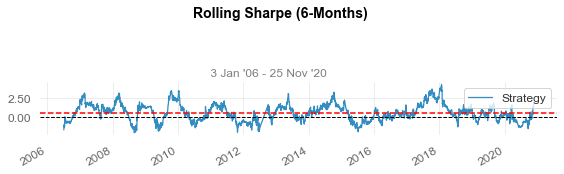

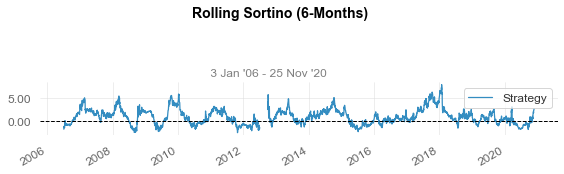

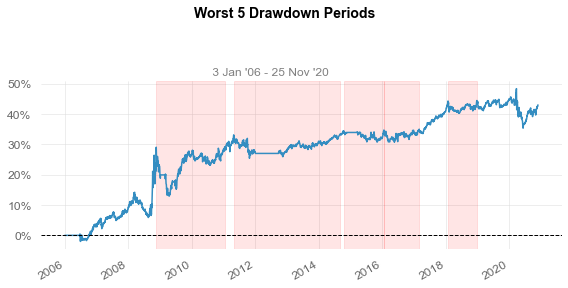

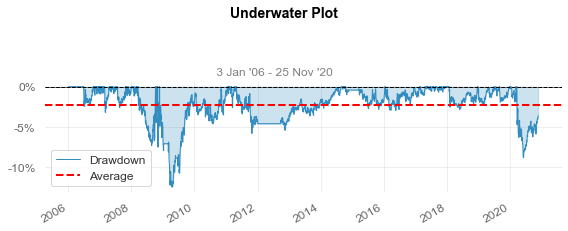

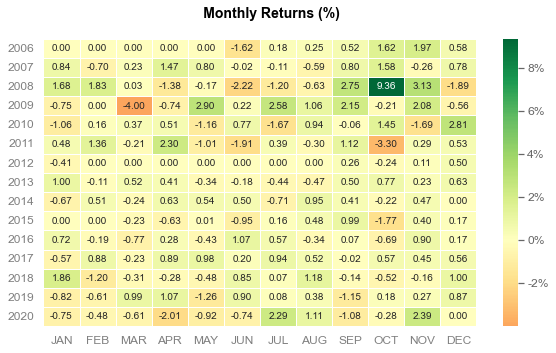

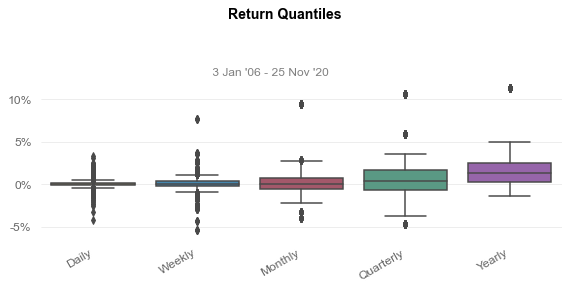

In [212]:
import quantstats as qs 

qs.reports.full(data_earnings['Tot'], benchmark = buy_and_hold_returns['Tot'])

## Creating equally weighted 

In [178]:
#creating benchmark

signal_df_eq_weight = signal_df.copy()
signal_df_eq_weight['n_sec_active'] = signal_df_eq_weight.apply(number_nan, axis = 1)
signal_df_eq_weight = signal_df_eq_weight.apply(lambda row: row/row['n_sec_active'], axis = 1)
signal_df_eq_weight.drop(columns =['n_sec_active'], inplace = True)
signal_df_eq_weight

,DBB,GLD,SLV,PPLT,DBA,DBO,UNG,CORN,SOYB,DBE,USO,UGA,GRU,GSG,FUE
Date,,,,,,,,,,,,,,,
2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-19,0.066667,0.066667,0.066667,0.066667,0.066667,-0.066667,-0.066667,0.066667,0.066667,-0.066667,-0.066667,-0.066667,0.066667,0.066667,0.066667
2020-11-20,0.066667,0.066667,0.066667,0.066667,0.066667,-0.066667,-0.066667,0.066667,0.066667,-0.066667,-0.066667,-0.066667,0.066667,0.066667,0.066667
2020-11-23,0.066667,0.066667,0.066667,0.066667,0.066667,-0.066667,-0.066667,0.066667,0.066667,-0.066667,-0.066667,-0.066667,0.066667,0.066667,0.066667


In [179]:
signal_eq_weight_return = hep.df_earnings(signal_df_eq_weight, data_r.fillna(0))
signal_eq_weight_return.index = pd.to_datetime(signal_eq_weight_return.index)
signal_eq_weight_return[120:]

,DBB,GLD,SLV,PPLT,DBA,DBO,UNG,CORN,SOYB,DBE,USO,UGA,GRU,GSG,FUE,Tot
Date,,,,,,,,,,,,,,,,
2006-06-26,NaN,0.005001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005001
2006-06-27,NaN,-0.010295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.010295
2006-06-28,NaN,-0.002427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002427
2006-06-29,NaN,0.034411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.034411
2006-06-30,NaN,-0.028730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.028730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-19,0.000400,-0.000125,-0.000384,-0.000626,-0.000259,-0.000090,0.002464,-0.000375,0.000187,-0.000069,-0.000207,-0.000470,-0.001007,-0.000059,0.000000,-0.000621
2020-11-20,0.000755,0.000202,0.000208,-0.000082,-0.000043,-0.000541,-0.001010,0.000094,0.000112,-0.000619,-0.000413,-0.000567,0.000000,0.000536,0.000000,-0.001368
2020-11-23,-0.001022,-0.001313,-0.001660,-0.001489,0.000520,-0.000716,-0.001061,0.000706,0.000671,-0.000477,-0.000569,-0.001092,0.001636,0.000472,0.004465,-0.000928


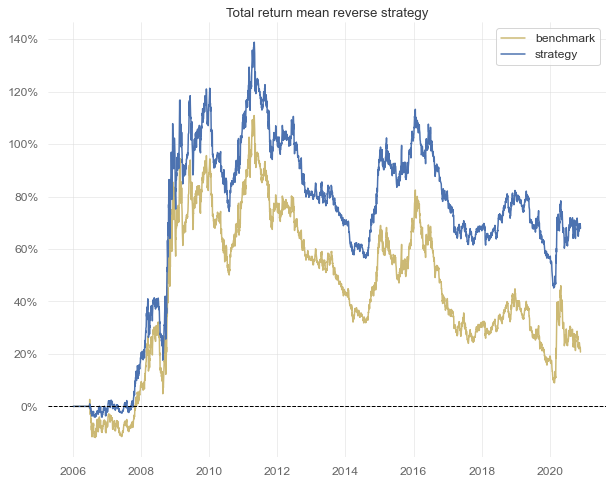

In [180]:
from quantstats.stats import compsum
from quantstats._plotting.core import format_pct_axis
from matplotlib.ticker import (
    FormatStrFormatter as _FormatStrFormatter,
    FuncFormatter as _FuncFormatter
)

#bench_return_try = bench_return[700:800]
#returns = dict_df['x1 leverage']['Tot']
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Total return mean reverse strategy')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(compsum(signal_eq_weight_return['Tot']), lw=1.5, color='y', alpha=1, label = 'benchmark')
ax.plot(compsum(data_earnings['Tot']), lw=1.5, color='b', alpha=1, label = 'strategy')
ax.axhline(0, ls="--", lw=1, color="#000000", zorder=2)
ax.yaxis.set_major_formatter(_FuncFormatter(format_pct_axis))
ax.legend()
fig = ax.get_figure()
fig.set_size_inches(10,8)
#fig.savefig('../img/returns_benchmark_'+ unique_name + '.png')

NameError: name 'bench_return' is not defined

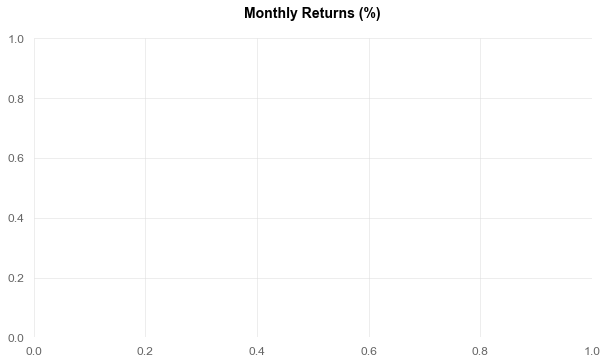

In [181]:

fig, ax = plt.subplots(figsize=figsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.set_facecolor('white')
ax.set_facecolor('white')

ax.set_title('Monthly Returns (%)\n', fontsize=14, y=.995,
             fontname=fontname, fontweight='bold', color='black')

returns = monthly_returns(bench_return['Tot'], eoy=eoy,compounded=compounded) * 100

#print(returns.div(100).add(1).cumprod(axis = 1)) #replace(0,1).cumprod(axis=1)['DEC']
returns['YEAR'] = returns.div(100).add(1).cumprod(axis = 1)['DEC']
returns['YEAR'] = returns['YEAR'].sub(1).mul(100)
#yearly_returns = returns.div(100).add(1).cumprod(axis=1)['DEC'] - 1
#returns['YEAR'] = yearly_returns *100
#returns

reversed_df = returns.iloc[::-1]

#display(returns)

ax = sns.heatmap(reversed_df, ax=ax, annot=True, center=0,
                annot_kws={"size": annot_size}, vmax = 10,
                fmt="0.2f", linewidths=2,
                square=square, cbar=cbar, cmap = 'gray',
                cbar_kws={'format': '%.0f%%'})

ax.tick_params(colors="#808080")
plt.xticks(rotation=0, fontsize=annot_size*1.2)
plt.yticks(rotation=0, fontsize=annot_size*1.2)
plt.subplots_adjust(hspace=0, bottom=0, top=1)
fig.tight_layout(w_pad=0, h_pad=0)
plt.savefig('../img/benchmark_table_montly_returns' + unique_name + '.png')
fig_table = fig 

In [ ]:
df_weighted